# Instagram time-series prediction

Libraries installation

In [1]:
%%capture
!pip install holidays

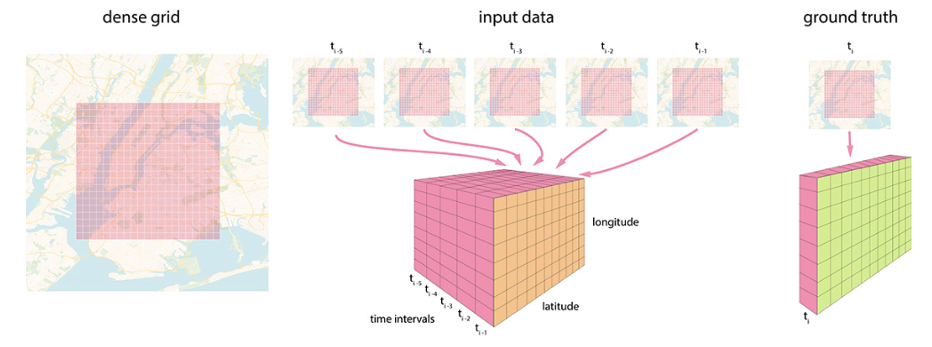

In [2]:
import numpy as np 
import pandas as pd 
import plotly.express as px
import datetime
from shapely import wkb

import os
import holidays
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from sklearn.preprocessing import LabelEncoder

Train, test, validation data reading

In [3]:
def unique_coord_generation(df_train_data):
    """
    Создаётся dataframe из уникальных координат, котоыре являются центрами квадратных полигонов 250м*250м
    """
    coord_dict = {}
    for i in df_train_data[["point"]].values:
        if i[0] not in coord_dict.keys():
            coord_dict[i[0]] = 1
        else:
            coord_dict[i[0]] += 1

    df_coord = pd.DataFrame(coord_dict, index=[0]).transpose().reset_index().rename({"index": "point", 0: "count"}, axis=1)
    df_coord["point_wkb"] = df_coord["point"].apply(lambda x: wkb.loads(x, hex=True))
    df_coord["coord"] = df_coord["point_wkb"].apply(lambda p: (p.x, p.y))
    df_coord["lat"] = df_coord["coord"].apply(lambda x: float(x[1]))
    df_coord["lon"] = df_coord["coord"].apply(lambda x: float(x[0]))
    df_coord.to_csv("/kaggle/working/unique_coordinates_count.csv", index=False)
    return df_coord


def df_op(df, ts_ms_name = "hour"):
    """
    Конвертация timestamp из dataframe в datetime
    """
    df["datetime"] = df[ts_ms_name].apply(lambda x: datetime.datetime.fromtimestamp(x))
    df.sort_values("datetime", inplace=True)
    df["point_wkb"] = df["point"].apply(lambda x: wkb.loads(x, hex=True))
    df["coord"] = df["point_wkb"].apply(lambda p: (p.x, p.y))
    return df

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if "valid" in filename:
            df_valid = pd.read_csv(os.path.join(dirname, filename))
            df_valid.rename({"hour": "timestamp"}, axis=1, inplace=True)
            df_valid = df_op(df_valid, "timestamp")
            # удаляем из валидационного датасета координаты не из полигона
            df_valid = df_valid[(df_valid["lat"] != 0.0) & (df_valid["lon"] != 0.0)]
        elif "train_data" in filename:
            print(f"Start: {datetime.datetime.now()}")
            # long-term operation, 6-8 min in kaggle, 15 min locally
            df_train_data = pd.read_csv(os.path.join(dirname, filename))
            df_train_data = df_op(df_train_data, "timestamp")
            print(f"Finish: {datetime.datetime.now()}")
        elif "unique_coordinates" in filename:
            # this is dataset, which generated from train dataframe 
#             df_coord = pd.read_csv(os.path.join(dirname, filename))
            try:
                df_coord = unique_coord_generation(df_train_data)
            except NameError:
                print(f"'df_train_data' is not defined")
        elif "test" in filename:
            df_test_data = pd.read_csv(os.path.join(dirname, filename))
            df_test_data.rename({"hour": "timestamp"}, axis=1, inplace=True)
            df_test_data = df_op(df_test_data, "timestamp")
        print(os.path.join(dirname, filename))
        
try:
    print(df_coord.shape[0])
except NameError:
    df_coord = unique_coord_generation(df_train_data)

'df_train_data' is not defined
/kaggle/input/predictions-instagram-publications/unique_coordinates_count.csv
/kaggle/input/predictions-instagram-publications/valid.csv
Start: 2022-11-23 21:15:26.761755
Finish: 2022-11-23 21:22:12.210947
/kaggle/input/predictions-instagram-publications/train_data.csv
/kaggle/input/predictions-instagram-publications/test.csv


In [5]:
# календарь праздников за 2 года, которые представлены в dataframe
holidays_years_list = [*range(df_train_data["datetime"].min().year, df_train_data["datetime"].max().year + 1)]
holidays_dict = holidays.RU(years=holidays_years_list)

def weekend_holiday_layout(df):
    # указываем является ли день праздничным
    df["holiday"] = df["datetime"].apply(lambda x: 1 if x in holidays_dict else 0)
    # указываем является ли день выходным или праздничным
    df['weekend'] = df['datetime'].apply(lambda x: 1 if x.weekday() >= 5 or x in holidays_dict else 0)
    # разделяем день, месяц, год, час
    df['weekday'] = df['datetime'].apply(lambda x: x.weekday())
    df['month'] = df['datetime'].apply(lambda x: x.month)
    df['day'] = df['datetime'].apply(lambda x: x.day)
    df['year'] = df['datetime'].apply(lambda x: x.year)
    df['hour'] = df['datetime'].apply(lambda x: x.hour)
    return df

df_train_data = weekend_holiday_layout(df_train_data)
df_test_data = weekend_holiday_layout(df_test_data)
df_valid = weekend_holiday_layout(df_valid)

In [6]:
df_train_data[["lon", "lat", "datetime", "holiday", "weekend"]].head(180000)

lon        lat            datetime  holiday  weekend
5218640  30.309158  59.941612 2019-01-01 00:00:00        1        1
5218657  30.329370  59.934863 2019-01-01 00:00:00        1        1
5218656  30.349582  59.944987 2019-01-01 00:00:00        1        1
5218655  30.226064  59.971970 2019-01-01 00:00:00        1        1
5218654  30.158690  59.991070 2019-01-01 00:00:00        1        1
...            ...        ...                 ...      ...      ...
842654   30.315895  59.937113 2019-01-12 04:00:00        0        1
842655   30.315895  59.937113 2019-01-12 04:00:00        0        1
842656   30.315895  59.937113 2019-01-12 04:00:00        0        1
842658   30.394498  59.937113 2019-01-12 04:00:00        0        1
842677   30.327124  59.937113 2019-01-12 04:00:00        0        1

[180000 rows x 5 columns]

In [7]:
def datetime_df_generate(df):
    dt_dict = {}
    for i in df[["datetime"]].values:
        if i[0] not in dt_dict.keys():
            dt_dict[i[0]] = 1
        else:
            dt_dict[i[0]] += 1

    df = pd.DataFrame(dt_dict, index=[0]).transpose().reset_index().rename({"index": "datetime", 0: "sum"}, axis=1)
    return df

In [8]:
df_train_datetime = datetime_df_generate(df_train_data)
df_val_datetime = df_valid.groupby(["point", "timestamp", "datetime", "month", "year", "day", "hour", "holiday", "weekend", "weekday", 'lat', 'lon'],
                      as_index=False)['sum'].sum().sort_values("timestamp")
df_test_datetime = df_test_data.groupby(["point", "timestamp", "datetime", "month", "year", "day", "hour", "holiday", "weekend", "weekday", 'lat', 'lon'], 
                                        as_index=False)['sum'].sum().sort_values("timestamp")

In [9]:
def time_series_print(time_series_dict: dict):
    for df_name in time_series_dict.keys():
        fig = px.line(time_series_dict[df_name], x='datetime', y="sum", title=f"Number of publications for all polygons in {df_name} data")
        fig.show()


time_series = {
    "train": df_train_datetime,
    "test": df_test_datetime,
    "validation": df_val_datetime
}

time_series_print(time_series)

In [10]:
spb_poly = [
    [30.017548,59.860836],
    [30.023041,59.813835],
    [30.16449,59.798615],
    [30.273667,59.81591],
    [30.345765,59.798871],
    [30.457001,59.823774],
    [30.599824,59.814091],
    [30.60669,59.860402],
    [30.612183,59.904578],
    [30.561371,59.950762],
    [30.581971,59.982088],
    [30.572358,60.004447],
    [30.483094,60.059063],
    [30.371514,60.089087],
    [30.305253,60.082055],
    [30.123978,60.04945],
    [30.038834,60.005123],
    [30.017548,59.860836] # дублирует первую координату
]

polygon_spb = Polygon(spb_poly)

In [11]:
# определяем принадлежность публикации выделенному полигону
df_train_data["in_polygon"] = df_train_data["coord"].apply(lambda x: polygon_spb.contains(Point(x)))

In [12]:
# отсекаем публикации из тренировочного сета, которые не входят в полигон
df_train_data_other = df_train_data[df_train_data["in_polygon"] == False]
df_train_data = df_train_data[df_train_data["in_polygon"] == True]

In [13]:
# функция визуализации временного ряда для конкретного поинта 
def polygon_visualization(df, point, columns=None, df_time_temp=None, visible=True):
    if type(point) == str:
        column_name = "point"
    elif type(point) == int or type(point) == np.int64:
        column_name = "label"
    else:
        return None
    if column_name in df.columns:
        part_df = df[df[column_name] == point]
        if columns is not None:
            if df_time_temp is not None:
                if part_df.shape[0] == 0:
                    print("Полигон не представлен в валидационной выборке")
                    return None
                df1_ = df_time_temp.copy()
                for col in columns:
                    if "sum" != col:
                        df1_.loc[:, col] = None
                df1 = df1_[['datetime'] + columns].copy()
                df2 = part_df[['datetime'] + columns].copy()
                df1.rename({"sum": "ground_truth"}, axis=1, inplace=True)
                df2.rename({"sum": "ground_truth"}, axis=1, inplace=True)
                columns = [c for c in columns if "sum" != c] + ["ground_truth"]
                fig = px.line(pd.concat([df1, df2]), x='datetime', y=columns, markers=True)
            else:
                columns = [c for c in columns if "sum" != c] + ["ground_truth"]
                fig = px.line(part_df.rename({"sum": "ground_truth"}, axis=1), x='datetime', y=columns, markers=True)
        else:
            df_time = datetime_df_generate(part_df)  
            fig = px.line(df_time.rename({"sum": "ground_truth"}, axis=1), x='datetime', y="ground_truth", markers=True)
        if visible:
            fig.show()
        fig = px.scatter_mapbox(
            part_df,
            lat="lat",
            lon="lon",
            color_discrete_sequence=["fuchsia"],
            zoom=12,
            height=300,
            width=400
        )
        if visible:
            fig.update_layout(mapbox_style="open-street-map")
            fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
            fig.show()
        return part_df
    else:
        return None

Проверка на то, что все координаты из валидационного, тестового датасетов есть в тренировочном

In [14]:
# уникальные координаты тестового датасета
df_test_coord = unique_coord_generation(df_test_data)
# уникальные координаты валидационного датасета
df_valid_coord = unique_coord_generation(df_valid)
# уникальные координаты тренировочного датасета
df_train_coord = unique_coord_generation(df_train_data)
df_train_delete_coord = unique_coord_generation(df_train_data_other)

assert df_test_coord.merge(df_train_coord, on="point", how="inner").shape[0] == df_test_coord.shape[0]
assert df_valid_coord.merge(df_train_coord, on="point", how="inner").shape[0] == df_valid_coord.shape[0]

Преобразуем координаты в label с помощью LabelEncoder

In [15]:
le = LabelEncoder()
df_train_coord['label'] = le.fit_transform(df_train_coord.point.values)
df_valid_coord['label'] = le.transform(df_valid_coord.point.values)
df_train_data['label'] = le.transform(df_train_data.point.values)
df_valid['label'] = le.transform(df_valid.point.values)
df_test_data['label'] = le.transform(df_test_data.point.values)

In [16]:
df_train_coord[["point", "label"]]

point  label
0     0101000020E6100000268147F5244F3E406DAFAAC186F8...   1027
1     0101000020E6100000DBC1F19351543E40DB251193A9F7...   6055
2     0101000020E610000091029C327E593E407916A554F5F8...   3911
3     0101000020E61000008D938B4CDF393E40F91CC68469FC...   3788
4     0101000020E61000002D1154E69F283E4076150862DBFE...   1217
...                                                 ...    ...
7010  0101000020E610000019822A1E0B563E40388968F5C0F1...    674
7011  0101000020E6100000B5C49A0E04693E40388968F5C0F1...   4893
7012  0101000020E6100000963DF4DB45353E40CDB8F9500301...   4043
7013  0101000020E6100000132D76D657583E407CC0CC729EF2...    562
7014  0101000020E6100000AC1A327F9D6D3E400C288C4EF3F7...   4658

[7015 rows x 2 columns]

In [17]:
# обратное ковертирование
print(le.transform(["0101000020E61000000FD8C18EA45A3E40CAE971F73AF74D40"]))
le.inverse_transform([448])

[448]


array(['0101000020E61000000FD8C18EA45A3E40CAE971F73AF74D40'], dtype=object)

Визуализация полигонов

In [18]:
p1 = "0101000020E61000000FD8C18EA45A3E40CAE971F73AF74D40"
polygon_visualization(df_valid, p1)

timestamp        lat        lon  \
63   1581253200  59.931487  30.354073   
645  1581260400  59.931487  30.354073   
320  1581444000  59.931487  30.354073   
123  1581778800  59.931487  30.354073   
110  1582117200  59.931487  30.354073   
511  1582358400  59.931487  30.354073   
233  1582531200  59.931487  30.354073   
157  1582894800  59.931487  30.354073   

                                                 point  sum      error  \
63   0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   17   3.004735   
645  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   14   5.754735   
320  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   18   7.754735   
123  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   12   1.154735   
110  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   12  10.754735   
511  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   11   9.754735   
233  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   19  17.754735   
157  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   22   9.754735   

               datetime                                    point_wkb  \
63  2020-02-09 13:00:00  POINT (30.35407345039863 59.93148701727075)   
645 2020-02-09 15:00:00  POINT (30.35407345039863 59.93148701727075)   
320 2020-02-11 18:00:00  POINT (30.35407345039863 59.93148701727075)   
123 2020-02-15 15:00:00  POINT (30.35407345039863 59.93148701727075)   
110 2020-02-19 13:00:00  POINT (30.35407345039863 59.93148701727075)   
511 2020-02-22 08:00:00  POINT (30.35407345039863 59.93148701727075)   
233 2020-02-24 08:00:00  POINT (30.35407345039863 59.93148701727075)   
157 2020-02-28 13:00:00  POINT (30.35407345039863 59.93148701727075)   

                                        coord  holiday  weekend  weekday  \
63   (30.354073450398626, 59.931487017270754)        0        1        6   
645  (30.354073450398626, 59.931487017270754)        0        1        6   
320  (30.354073450398626, 59.931487017270754)        0        0        1   
123  (30.354073450398626, 59.931487017270754)        0        1        5   
110  (30.354073450398626, 59.931487017270754)        0        0        2   
511  (30.354073450398626, 59.931487017270754)        0        1        5   
233  (30.354073450398626, 59.931487017270754)        0        0        0   
157  (30.354073450398626, 59.931487017270754)        0        0        4   

     month  day  year  hour  label  
63       2    9  2020    13    448  
645      2    9  2020    15    448  
320      2   11  2020    18    448  
123      2   15  2020    15    448  
110      2   19  2020    13    448  
511      2   22  2020     8    448  
233      2   24  2020     8    448  
157      2   28  2020    13    448

In [19]:
p1 = "0101000020E61000000FD8C18EA45A3E40CAE971F73AF74D40"
polygon_visualization(df_test_data, p1)

timestamp        lat        lon  \
417  1580536800  59.931487  30.354073   
108  1580580000  59.931487  30.354073   
445  1580583600  59.931487  30.354073   
447  1580590800  59.931487  30.354073   
316  1580630400  59.931487  30.354073   
644  1580742000  59.931487  30.354073   
518  1580817600  59.931487  30.354073   
52   1581055200  59.931487  30.354073   
80   1581411600  59.931487  30.354073   
29   1581526800  59.931487  30.354073   
573  1581570000  59.931487  30.354073   
454  1581757200  59.931487  30.354073   
679  1581840000  59.931487  30.354073   
620  1581930000  59.931487  30.354073   
512  1582570800  59.931487  30.354073   
411  1582725600  59.931487  30.354073   
634  1582729200  59.931487  30.354073   
152  1582786800  59.931487  30.354073   

                                                 point  sum      error  \
417  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...    7   1.088069   
108  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   27   5.504735   
445  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   23   4.504735   
447  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   18   4.754735   
316  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   16  14.754735   
644  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   17   4.421402   
518  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   33   9.754735   
52   0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   10   3.754735   
80   0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   29   3.588069   
29   0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   14   5.754735   
573  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...    7   5.754735   
454  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   10   8.754735   
679  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   10   0.421402   
620  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   10   2.088069   
512  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   24   6.754735   
411  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   22  20.754735   
634  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   17   3.004735   
152  0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...   14  12.754735   

               datetime                                    point_wkb  \
417 2020-02-01 06:00:00  POINT (30.35407345039863 59.93148701727075)   
108 2020-02-01 18:00:00  POINT (30.35407345039863 59.93148701727075)   
445 2020-02-01 19:00:00  POINT (30.35407345039863 59.93148701727075)   
447 2020-02-01 21:00:00  POINT (30.35407345039863 59.93148701727075)   
316 2020-02-02 08:00:00  POINT (30.35407345039863 59.93148701727075)   
644 2020-02-03 15:00:00  POINT (30.35407345039863 59.93148701727075)   
518 2020-02-04 12:00:00  POINT (30.35407345039863 59.93148701727075)   
52  2020-02-07 06:00:00  POINT (30.35407345039863 59.93148701727075)   
80  2020-02-11 09:00:00  POINT (30.35407345039863 59.93148701727075)   
29  2020-02-12 17:00:00  POINT (30.35407345039863 59.93148701727075)   
573 2020-02-13 05:00:00  POINT (30.35407345039863 59.93148701727075)   
454 2020-02-15 09:00:00  POINT (30.35407345039863 59.93148701727075)   
679 2020-02-16 08:00:00  POINT (30.35407345039863 59.93148701727075)   
620 2020-02-17 09:00:00  POINT (30.35407345039863 59.93148701727075)   
512 2020-02-24 19:00:00  POINT (30.35407345039863 59.93148701727075)   
411 2020-02-26 14:00:00  POINT (30.35407345039863 59.93148701727075)   
634 2020-02-26 15:00:00  POINT (30.35407345039863 59.93148701727075)   
152 2020-02-27 07:00:00  POINT (30.35407345039863 59.93148701727075)   

                                        coord  holiday  weekend  weekday  \
417  (30.354073450398626, 59.931487017270754)        0        1        5   
108  (30.354073450398626, 59.931487017270754)        0        1        5   
445  (30.354073450398626, 59.931487017270754)        0        1        5   
447  (30.354073450398626, 59.931487017270754)        0        1        5   
316  (30.354073450398626, 59.931487017270754)        0        1       

In [20]:
p2 = "0101000020E6100000268147F5244F3E406DAFAAC186F84D40"
polygon_visualization(df_train_data, p2)

timestamp        lon        lat  likescount  commentscount  \
5218640  1546300800  30.309158  59.941612          72              2   
5218790  1546300800  30.309158  59.941612          37              2   
5218787  1546300800  30.309158  59.941612          61              5   
5218810  1546300800  30.309158  59.941612         223             12   
5218540  1546300800  30.309158  59.941612          18              0   
...             ...        ...        ...         ...            ...   
2613315  1580475600  30.309158  59.941612         182             75   
2622560  1580479200  30.309158  59.941612          40              1   
2613935  1580482800  30.309158  59.941612          32              3   
2620543  1580500800  30.309158  59.941612          52              0   
2621309  1580504400  30.309158  59.941612          75              0   

         symbols_cnt  words_cnt  hashtags_cnt  mentions_cnt  links_cnt  ...  \
5218640           14          2             0             0          0  ...   
5218790           33          3             0             0          0  ...   
5218787            8          1             0             0          0  ...   
5218810           33          0             4             0          0  ...   
5218540            0          0             0             0          0  ...   
...              ...        ...           ...           ...        ...  ...   
2613315         1587        152             0             0          0  ...   
2622560            9          1             0             0          0  ...   
2613935           30          2             3             0          0  ...   
2620543            0          0             0             0          0  ...   
2621309            2          0             0             0          0  ...   

                                           coord holiday weekend weekday  \
5218640  (30.309157686192655, 59.94161244234315)       1       1       1   
5218790  (30.309157686192655, 59.94161244234315)       1       1       1   
5218787  (30.309157686192655, 59.94161244234315)       1       1       1   
5218810  (30.309157686192655, 59.94161244234315)       1       1       1   
5218540  (30.309157686192655, 59.94161244234315)       1       1       1   
...                                          ...     ...     ...     ...   
2613315  (30.309157686192655, 59.94161244234315)       0       0       4   
2622560  (30.309157686192655, 59.94161244234315)       0       0       4   
2613935  (30.309157686192655, 59.94161244234315)       0       0       4   
2620543  (30.309157686192655, 59.94161244234315)       0       0       4   
2621309  (30.309157686192655, 59.94161244234315)       0       0       4   

        month  day  year  hour  in_polygon  label  
5218640     1    1  2019     0        True   1027  
5218790     1    1  2019     0        True   1027  
5218787     1    1  2019     0        True   1027  
5218810     1    1  2019     0        True   1027  
5218540     1    1  2019     0        True   1027  
...       ...  ...   ...   ...         ...    ...  
2613315     1   31  2020    13        True   1027  
2622560     1   31  2020    14        True   1027  
2613935     1   31  2020    15        True   1027  
2620543     1   31  2020    20        True   1027  
2621309     1   31  2020    21        True   1027  

[17258 rows x 24 columns]

In [21]:
# публикации, которые были привязаны к координатам не из выбранного полигона
df_train_data_other.shape[0]

76567

In [22]:
# координаты, которые быди удалены их тренировчоного датасета
df_train_delete_coord.shape[0]

26

In [23]:
df_spb_poly = pd.DataFrame(spb_poly, columns = ["lon", "lat"])

In [24]:
fig = px.scatter_mapbox(
    df_valid,
    lat="lat",
    lon="lon",
    color_discrete_sequence=["fuchsia"],
    zoom=10,
    height=600
)
fig2 = px.line_mapbox(df_spb_poly, lat ="lat", lon="lon")
fig.add_trace(fig2.data[0])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Multiply the degrees of separation of longitude and latitude by 111,139 to get the corresponding linear distances in meters.

In [25]:
fig = px.scatter_mapbox(
    df_train_delete_coord,
    lat="lat",
    lon="lon",
    hover_data=["count"],
    color_discrete_sequence=["fuchsia"],
    zoom=10,
    height=600
)
fig2 = px.line_mapbox(df_spb_poly, lat ="lat", lon="lon")

fig.add_trace(fig2.data[0])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [26]:
fig = px.scatter_mapbox(
    df_train_coord,
    lat="lat",
    lon="lon",
    hover_data=["count"],
    color_discrete_sequence=["fuchsia"],
    zoom=10,
    height=600
)
fig2 = px.line_mapbox(df_spb_poly, lat ="lat", lon="lon")

fig.add_trace(fig2.data[0])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [27]:
fig = px.scatter_mapbox(
    df_coord,
    lat="lat",
    lon="lon",
    hover_data=["count"],
    color_discrete_sequence=["fuchsia"],
    zoom=10,
    height=600
)
fig2 = px.line_mapbox(df_spb_poly, lat ="lat", lon="lon")

fig.add_trace(fig2.data[0])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [28]:
fig = px.scatter_mapbox(
    df_test_data,
    lat="lat",
    lon="lon",
    color_discrete_sequence=["fuchsia"],
    zoom=10,
    height=600
)
fig2 = px.line_mapbox(df_spb_poly, lat ="lat", lon="lon")
fig.add_trace(fig2.data[0])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Приведение данных к единому виду. Сгруппируем данные по полигонам: время и координаты покажут количество публикаций в локации за час

In [29]:
df_train_data

timestamp        lon        lat  likescount  commentscount  \
5218640  1546300800  30.309158  59.941612          72              2   
5218657  1546300800  30.329370  59.934863          26              0   
5218656  1546300800  30.349582  59.944987          26              0   
5218655  1546300800  30.226064  59.971970          16              0   
5218654  1546300800  30.158690  59.991070          10              0   
...             ...        ...        ...         ...            ...   
2622352  1580511600  30.282208  59.906723           4              0   
2622351  1580511600  30.212589  59.978713          29              1   
2622350  1580511600  30.336107  59.931487          17              0   
2622358  1580511600  30.327124  59.935988          56              0   
2623730  1580511600  30.333861  59.928111          15              0   

         symbols_cnt  words_cnt  hashtags_cnt  mentions_cnt  links_cnt  ...  \
5218640           14          2             0             0          0  ...   
5218657            0          0             0             0          0  ...   
5218656           46          2             3             0          0  ...   
5218655           37          0             3             0          0  ...   
5218654            0          0             0             0          0  ...   
...              ...        ...           ...           ...        ...  ...   
2622352           34          3             0             0          0  ...   
2622351          373         41             0             0          0  ...   
2622350          596         31            30             1          0  ...   
2622358           29          4             0             0          0  ...   
2623730          101          5             3             1          0  ...   

                                            coord holiday weekend weekday  \
5218640   (30.309157686192655, 59.94161244234315)       1       1       1   
5218657    (30.32936978008534, 59.93486250245379)       1       1       1   
5218656    (30.34958187397803, 59.94498689709594)       1       1       1   
5218655   (30.226063522411597, 59.97197017358298)       1       1       1   
5218654    (30.15868987610263, 59.99107003588408)       1       1       1   
...                                           ...     ...     ...     ...   
2622352   (30.282208227669067, 59.90672296121975)       0       0       4   
2622351  (30.212588793149802, 59.978712559797806)       0       0       4   
2622350   (30.33610714471624, 59.931487017270754)       0       0       4   
2622358   (30.32712399187504, 59.935987587846995)       0       0       4   
2623730  (30.333861356505942, 59.928111188564486)       0       0       4   

        month  day  year  hour  in_polygon  label  
5218640     1    1  2019     0        True   1027  
5218657     1    1  2019     0        True   6055  
5218656     1    1  2019     0        True   3911  
5218655     1    1  2019     0        True   3788  
5218654     1    1  2019     0        True   1217  
...       ...  ...   ...   ...         ...    ...  
2622352     1   31  2020    23        True   1342  
2622351     1   31  2020    23        True    489  
2622350     1   31  2020    23        True    698  
2622358     1   31  2020    23        True    824  
2623730     1   31  2020    23        True   2473  

[8449959 rows x 24 columns]

In [30]:
df_train_data.columns

Index(['timestamp', 'lon', 'lat', 'likescount', 'commentscount', 'symbols_cnt',
       'words_cnt', 'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt',
       'point', 'datetime', 'point_wkb', 'coord', 'holiday', 'weekend',
       'weekday', 'month', 'day', 'year', 'hour', 'in_polygon', 'label'],
      dtype='object')

In [31]:
df_train_data["sum"] = 1
df_train_group = df_train_data.groupby(
    ["point", "timestamp", "datetime", "month", "year", "day", "hour", "holiday", "weekend", "label", "weekday", 'lat', 'lon'],
    as_index=False
).size()
df_train_group.rename({"size": "sum"}, axis=1, inplace=True)
df_train_group = df_train_group.sort_values("timestamp")

In [32]:
df_train_group["sum"].describe().astype(int)

count    3625209
mean           2
std            4
min            1
25%            1
50%            1
75%            2
max          600
Name: sum, dtype: int64

In [33]:
popular_point = df_train_group[df_train_group["sum"] == df_train_group["sum"].max()]["label"].values[0]

In [34]:
polygon_visualization(df_train_data, popular_point)

timestamp        lon        lat  likescount  commentscount  \
8210300  1565456400  30.219326  59.973094          20              0   
8210315  1565456400  30.219326  59.973094          87              9   
8210415  1565456400  30.219326  59.973094          59              1   
8210342  1565456400  30.219326  59.973094          16              0   
8209973  1565456400  30.219326  59.973094           9              0   
...             ...        ...        ...         ...            ...   
2619978  1580500800  30.219326  59.973094          33             12   
2621661  1580504400  30.219326  59.973094         117              1   
2620890  1580504400  30.219326  59.973094           6              1   
2622169  1580508000  30.219326  59.973094          25              0   
2621787  1580508000  30.219326  59.973094          22              0   

         symbols_cnt  words_cnt  hashtags_cnt  mentions_cnt  links_cnt  ...  \
8210300            0          0             0             0          0  ...   
8210315           13          1             0             0          0  ...   
8210415           31          2             0             0          0  ...   
8210342           33          2             2             0          0  ...   
8209973           96          9             0             0          0  ...   
...              ...        ...           ...           ...        ...  ...   
2619978          100          4             2             0          0  ...   
2621661         1243        105             0             0          0  ...   
2620890           60          3             5             0          0  ...   
2622169           66          5             3             0          0  ...   
2621787          135          3             9             0          0  ...   

         holiday weekend weekday month day  year  hour  in_polygon  label  sum  
8210300        0       1       5     8  10  2019    17        True   2160    1  
8210315        0       1       5     8  10  2019    17        True   2160    1  
8210415        0       1       5     8  10  2019    17        True   2160    1  
8210342        0       1       5     8  10  2019    17        True   2160    1  
8209973        0       1       5     8  10  2019    17        True   2160    1  
...          ...     ...     ...   ...  ..   ...   ...         ...    ...  ...  
2619978        0       0       4     1  31  2020    20        True   2160    1  
2621661        0       0       4     1  31  2020    21        True   2160    1  
2620890        0       0       4     1  31  2020    21        True   2160    1  
2622169        0       0       4     1  31  2020    22        True   2160    1  
2621787        0       0       4     1  31  2020    22        True   2160    1  

[70037 rows x 25 columns]

In [35]:
X_train = df_train_group.drop(["point", "sum", "timestamp", "datetime", 'lat', 'lon'], axis=1)
y_train = df_train_group["sum"].to_numpy()

In [36]:
X_valid = df_valid.drop(['timestamp', 'point', 'lat', 'lon', 'sum', "coord", "point_wkb", "error", "datetime"], axis=1)
y_valid = df_valid['sum'].to_numpy()

X_valid = X_valid[X_train.columns.to_list()] 

In [37]:
X_test = df_test_data.drop(['timestamp', 'point', 'lat', 'lon', 'sum', "coord", "point_wkb", "error", "datetime"], axis=1)
y_test = df_test_data['sum'].to_numpy()

X_test = X_test[X_train.columns.to_list()] 

## Model

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import shuffle
import xgboost as xgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [39]:
X_train, y_train = shuffle(X_train, y_train)

In [40]:
def metrics(prediction, ground_truth):
    return np.mean(np.abs(prediction - ground_truth) / prediction)

## CatBoostRegressor

In [41]:
iterations = [100 * i for i in range(6, 10)]
depths = [i for i in range (6, 11)]
data_leaf = [i for i in range(1, 3)]

catboost_best_m = 3 
catboost_best_i = 1
catboost_best_d = 1
catboost_best_l_d = 1

for d in depths:
    for d_l in data_leaf:
        for i in iterations:
            catboost = CatBoostRegressor(
                depth=d, 
                min_data_in_leaf=d_l,
                iterations=i,
                verbose=False, 
                random_state=42, 
                task_type='GPU'
            )
            catboost.fit(X_train, y_train)

            catboost_pred_test = catboost.predict(X_test)
            catboost_pred = catboost.predict(X_valid)

            val_m = metrics(catboost_pred, y_valid)
            if val_m < catboost_best_m:
                catboost_best_m = val_m
                catboost_best_i = i
                catboost_best_d = d
                catboost_best_l_d = d_l
            print(f"iterations: {i}, max_depth: {d}, min_data_in_leaf: {d_l}, Valid: {val_m:.2f}, Test: {metrics(catboost_pred_test, y_test):.2f}")
        
print(f"Best metric {catboost_best_m:.2f}\n iterations: {catboost_best_i}, max_depth: {catboost_best_d}, min_data_in_leaf: {catboost_best_l_d}")

iterations: 600, max_depth: 6, min_data_in_leaf: 1, Valid: 1.96, Test: 1.98
iterations: 700, max_depth: 6, min_data_in_leaf: 1, Valid: 1.95, Test: 1.99
iterations: 800, max_depth: 6, min_data_in_leaf: 1, Valid: 1.94, Test: 1.98
iterations: 900, max_depth: 6, min_data_in_leaf: 1, Valid: 1.95, Test: 1.96
iterations: 600, max_depth: 6, min_data_in_leaf: 2, Valid: 1.96, Test: 1.98
iterations: 700, max_depth: 6, min_data_in_leaf: 2, Valid: 1.95, Test: 1.99
iterations: 800, max_depth: 6, min_data_in_leaf: 2, Valid: 1.94, Test: 1.98
iterations: 900, max_depth: 6, min_data_in_leaf: 2, Valid: 1.95, Test: 1.96
iterations: 600, max_depth: 7, min_data_in_leaf: 1, Valid: 1.91, Test: 1.95
iterations: 700, max_depth: 7, min_data_in_leaf: 1, Valid: 1.95, Test: 2.01
iterations: 800, max_depth: 7, min_data_in_leaf: 1, Valid: 1.93, Test: 1.98
iterations: 900, max_depth: 7, min_data_in_leaf: 1, Valid: 1.92, Test: 1.99
iterations: 600, max_depth: 7, min_data_in_leaf: 2, Valid: 1.91, Test: 1.95
iterations: 

In [42]:
catboost = CatBoostRegressor(
                depth=catboost_best_d, 
                min_data_in_leaf=catboost_best_l_d,
                iterations=catboost_best_i,
                verbose=False, 
                random_state=42, 
                task_type='GPU'
            )

catboost.fit(X_train, y_train)

In [43]:
catboost.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'RMSE',
 'iterations': 800,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'devices': '-1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'meta_l2_frequency': 0,
 'random_seed': 42,
 'depth': 10,
 'border_count': 128,
 'min_fold_size': 100,
 'data_partition': 'DocParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 

In [44]:
catboost_pred_test = catboost.predict(X_test)
catboost_pred = catboost.predict(X_valid)
print(f"Catboost metric for test: {metrics(catboost_pred_test, y_test):.2f}")
print(f"Catboost metric for valid: {metrics(catboost_pred, y_valid):.2f}")

Catboost metric for test: 2.11
Catboost metric for valid: 1.91


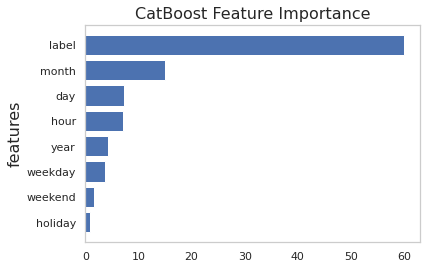

In [45]:
feature_importance = catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.ylabel('features', fontsize = 16)
plt.title('СatBoost Feature Importance', fontsize = 16)
plt.grid(visible=None)
plt.show()

## XGBRegressor

In [46]:
estimators = [100 * i for i in range(1, 7)]
depths = [i for i in range (5, 10)]

In [47]:
xgb_best_met = 10
xgb_best_e = 1
xgb_best_d = 1
for e in estimators:
    for d in depths:
        xgboost = XGBRegressor(
            tree_method='gpu_hist',
            subsample=0.8, 
            n_estimators=e, 
            max_depth=d,
            min_child_weight=1,
            random_state=42
        )

        xgboost.fit(X_train, y_train)

        xgb_pred_test = xgboost.predict(X_test)
        xgb_pred = xgboost.predict(X_valid)
        
        val_m = metrics(xgb_pred, y_valid)
        if val_m < xgb_best_met:
            xgb_best_met = val_m
            xgb_best_e = e
            xgb_best_d = d
        print(f"Estimators: {e}, Max Depth: {d}, Valid: {val_m:.2f}, Test: {metrics(xgb_pred_test, y_test):.2f}")
        
print(f"Best metric {xgb_best_met:.2f}\n est: {xgb_best_e}, depth: {xgb_best_d}")

Estimators: 100, Max Depth: 5, Valid: 1.48, Test: 1.49
Estimators: 100, Max Depth: 6, Valid: 1.54, Test: 1.48
Estimators: 100, Max Depth: 7, Valid: 1.43, Test: 1.42
Estimators: 100, Max Depth: 8, Valid: 1.43, Test: 1.39
Estimators: 100, Max Depth: 9, Valid: 1.44, Test: 1.39
Estimators: 200, Max Depth: 5, Valid: 1.40, Test: 1.40
Estimators: 200, Max Depth: 6, Valid: 1.42, Test: 1.36
Estimators: 200, Max Depth: 7, Valid: 1.41, Test: 1.36
Estimators: 200, Max Depth: 8, Valid: 1.46, Test: 1.41
Estimators: 200, Max Depth: 9, Valid: 1.51, Test: 1.42
Estimators: 300, Max Depth: 5, Valid: 1.40, Test: 1.24
Estimators: 300, Max Depth: 6, Valid: 1.43, Test: 1.36
Estimators: 300, Max Depth: 7, Valid: 1.44, Test: 1.41
Estimators: 300, Max Depth: 8, Valid: 1.33, Test: 1.56
Estimators: 300, Max Depth: 9, Valid: 1.37, Test: 1.41
Estimators: 400, Max Depth: 5, Valid: 1.40, Test: 1.30
Estimators: 400, Max Depth: 6, Valid: 1.34, Test: 1.36
Estimators: 400, Max Depth: 7, Valid: 1.46, Test: 1.34
Estimators

In [48]:
xgboost = XGBRegressor(
    tree_method='gpu_hist',
    subsample=0.8, 
    n_estimators=xgb_best_e, 
    max_depth=xgb_best_d,
    min_child_weight=1,
    random_state=42
)

xgboost.fit(X_train, y_train)

xgb_pred_test = xgboost.predict(X_test)
xgb_pred = xgboost.predict(X_valid)

print(f"xgboost metric for test: {metrics(xgb_pred_test, y_test):.2f}")
print(f"xgboost metric for valid: {metrics(xgb_pred, y_valid):.2f}")

xgboost metric for test: 1.43
xgboost metric for valid: 0.38


In [49]:
xgboost.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': 0,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 8,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': 'gpu_hist',
 'validate_parameters': 1,
 'verbosity': None}

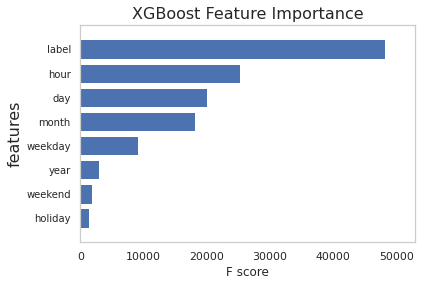

In [50]:
xgb.plot_importance(xgboost, height = 0.8, grid = False, show_values = False)
plt.title('XGBoost Feature Importance', fontsize = 16)
plt.yticks(fontsize = 10)
plt.ylabel('features', fontsize = 16)
# plt.xaxis.set_visible(True)
plt.show()

## LightGBM

In [51]:
import lightgbm as lgb

In [52]:
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt' # GradientBoostingDecisionTree
params['objective'] = 'regression' # regression task
params['max_depth'] = 10
params['num_leaves'] = 30
params['min_data_in_leaf'] = 30
params['verbose'] = -1
params['device'] = 'gpu'

In [53]:
lgb_model = lgb.train(params, d_train, 100)

In [54]:
lgb_model.params

{'learning_rate': 0.05,
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'max_depth': 10,
 'num_leaves': 30,
 'min_data_in_leaf': 30,
 'verbose': -1,
 'device': 'gpu',
 'num_iterations': 100,
 'early_stopping_round': None}

In [55]:
lightgbm_pred_test = lgb_model.predict(X_test)
lightgbm_pred = lgb_model.predict(X_valid)

print(f"lightgbm metric for test: {metrics(lightgbm_pred_test, y_test):.2f}")
print(f"lightgbm metric for valid: {metrics(lightgbm_pred, y_valid):.2f}")

lightgbm metric for test: 2.09
lightgbm metric for valid: 2.04


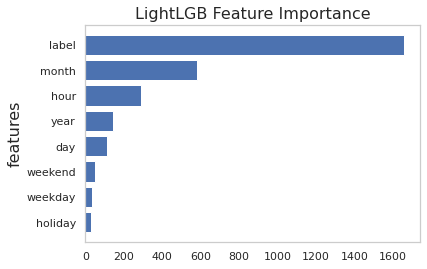

In [56]:
feature_importance = lgb_model.feature_importance()
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.ylabel('features', fontsize = 16)
plt.title('LightLGB Feature Importance', fontsize = 16)
plt.grid(visible=None)
plt.show()

## Visualization ground truth with predictions

In [57]:
df_valid["catboost_pred"] = catboost_pred
df_valid["catboost_error"] = df_valid[["sum", "catboost_pred"]].apply(lambda x: metrics(x[0], x[1]), axis=1)

df_valid["xgboost_pred"] = xgb_pred
df_valid["xgboost_error"] = df_valid[["sum", "xgboost_pred"]].apply(lambda x: metrics(x[0], x[1]), axis=1)

df_valid["lightgbm_pred"] = lightgbm_pred
df_valid["lightgbm_error"] = df_valid[["sum", "lightgbm_pred"]].apply(lambda x: metrics(x[0], x[1]), axis=1)


In [58]:
df_test_data["catboost_pred"] = catboost_pred_test
df_test_data["catboost_error"] = df_test_data[["sum", "catboost_pred"]].apply(lambda x: metrics(x[0], x[1]), axis=1)

df_test_data["xgboost_pred"] = xgb_pred_test
df_test_data["xgboost_error"] = df_test_data[["sum", "xgboost_pred"]].apply(lambda x: metrics(x[0], x[1]), axis=1)

df_test_data["lightgbm_pred"] = lightgbm_pred_test
df_test_data["lightgbm_error"] = df_test_data[["sum", "lightgbm_pred"]].apply(lambda x: metrics(x[0], x[1]), axis=1)


In [59]:
df_test_data[["label", "sum", "catboost_pred", "xgboost_pred", "lightgbm_pred"]]

label  sum  catboost_pred  xgboost_pred  lightgbm_pred
417    448    7       2.423826      3.853279       1.967628
641   5311    8       1.934842      2.944658       2.185232
171   5614   13       2.591404      3.942543       3.408445
167   4174    6       4.266414      8.883973       4.738258
64    4326    7       4.652429      6.030183       3.828089
..     ...  ...            ...           ...            ...
353    711   19       8.994922     20.392929       9.359353
496   2360   12       2.574680      4.021558       2.934549
499   5931    6       3.269336      4.405085       2.851057
436   5393   37       5.727991      8.729431       8.064681
168   4619   13       3.939491      5.911263       2.861517

[700 rows x 5 columns]

In [60]:
df_valid[["label", "sum", "catboost_pred", "xgboost_pred", "lightgbm_pred"]]

label  sum  catboost_pred  xgboost_pred  lightgbm_pred
595   5217   12       5.649792      5.710732       3.568902
594   4768    6       1.996283      4.151893       2.378419
145   2110    6       3.219800     11.231422       7.456655
376   5311   11       3.030718      5.208114       3.049263
551   2983   25       8.260894     40.105797      16.518908
..     ...  ...            ...           ...            ...
85    2566   26       3.646670      6.159877       3.988207
211   1446    6       2.936263      1.948533       1.902856
518   6283    5       1.822499      2.314631       1.927036
316   4409   13       6.266845     13.948371       4.707929
699   2796   18      10.959408     19.394243      22.838726

[686 rows x 5 columns]

In [61]:
len(df_valid["point"].unique())

154

In [62]:
fig = px.line(
    df_test_data.sort_values("label").rename({"sum": "ground_truth"}, axis=1),
    x = "label",
    y = ["ground_truth", "xgboost_pred", "catboost_pred", "lightgbm_pred"],
    hover_data = ["datetime"],
    title=f"Predictions on test data",
    markers=True)
fig.show()

In [63]:
fig = px.line(
    df_valid.sort_values("label").rename({"sum": "ground_truth"}, axis=1),
    x = "label",
    y = ["ground_truth", "xgboost_pred", "catboost_pred", "lightgbm_pred"],
    hover_data = ["datetime"],
    title=f"Predictions on validation data",
    markers=True)
fig.show()

In [64]:
populars_polygon = df_train_group[["sum", "label"]].sort_values("sum").groupby(["label"]).size().reset_index().sort_values(0, ascending=False)["label"].values
populars_polygon

array([2796, 2662, 4454, ..., 1447, 4842, 7014])

In [65]:
df_train_group[["sum", "label"]].sort_values("sum").groupby(["label"]).size().reset_index().sort_values(0, ascending=False).head(1003)

label     0
2796   2796  9119
2662   2662  8738
4454   4454  8574
1131   1131  8562
5393   5393  8552
...     ...   ...
3907   3907   918
6370   6370   913
1454   1454   913
4717   4717   910
3042   3042   910

[1003 rows x 2 columns]

### Popular polygon (Saint Isaac's Cathedral)

In [66]:
df_train_temp = polygon_visualization(df_train_group, populars_polygon[0], columns=["sum"], visible=False)
polygon_visualization(df_test_data, populars_polygon[0], columns=["sum", "catboost_pred", "xgboost_pred", "lightgbm_pred"], df_time_temp=df_train_temp)

timestamp        lat        lon  \
76   1580594400  59.933737  30.306912   
40   1580918400  59.933737  30.306912   
460  1580994000  59.933737  30.306912   
494  1581188400  59.933737  30.306912   
688  1581285600  59.933737  30.306912   
289  1581310800  59.933737  30.306912   
231  1581501600  59.933737  30.306912   
501  1581818400  59.933737  30.306912   
441  1581980400  59.933737  30.306912   

                                                 point  sum     error  \
76   0101000020E6100000669634C7914E3E407AB3D8B484F7...   25  2.326164   
40   0101000020E6100000669634C7914E3E407AB3D8B484F7...   34  4.421402   
460  0101000020E6100000669634C7914E3E407AB3D8B484F7...   36  2.754735   
494  0101000020E6100000669634C7914E3E407AB3D8B484F7...   28  1.865846   
688  0101000020E6100000669634C7914E3E407AB3D8B484F7...   14  1.192672   
289  0101000020E6100000669634C7914E3E407AB3D8B484F7...   15  1.754735   
231  0101000020E6100000669634C7914E3E407AB3D8B484F7...   30  6.254735   
501  0101000020E6100000669634C7914E3E407AB3D8B484F7...   10  8.754735   
441  0101000020E6100000669634C7914E3E407AB3D8B484F7...   18  0.754735   

               datetime                                    point_wkb  \
76  2020-02-01 22:00:00  POINT (30.30691189798235 59.93373737889392)   
40  2020-02-05 16:00:00  POINT (30.30691189798235 59.93373737889392)   
460 2020-02-06 13:00:00  POINT (30.30691189798235 59.93373737889392)   
494 2020-02-08 19:00:00  POINT (30.30691189798235 59.93373737889392)   
688 2020-02-09 22:00:00  POINT (30.30691189798235 59.93373737889392)   
289 2020-02-10 05:00:00  POINT (30.30691189798235 59.93373737889392)   
231 2020-02-12 10:00:00  POINT (30.30691189798235 59.93373737889392)   
501 2020-02-16 02:00:00  POINT (30.30691189798235 59.93373737889392)   
441 2020-02-17 23:00:00  POINT (30.30691189798235 59.93373737889392)   

                                       coord  holiday  ...  day  year  hour  \
76   (30.306911897982353, 59.93373737889392)        0  ...    1  2020    22   
40   (30.306911897982353, 59.93373737889392)        0  ...    5  2020    16   
460  (30.306911897982353, 59.93373737889392)        0  ...    6  2020    13   
494  (30.306911897982353, 59.93373737889392)        0  ...    8  2020    19   
688  (30.306911897982353, 59.93373737889392)        0  ...    9  2020    22   
289  (30.306911897982353, 59.93373737889392)        0  ...   10  2020     5   
231  (30.306911897982353, 59.93373737889392)        0  ...   12  2020    10   
501  (30.306911897982353, 59.93373737889392)        0  ...   16  2020     2   
441  (30.306911897982353, 59.93373737889392)        0  ...   17  2020    23   

     label  catboost_pred  catboost_error  xgboost_pred  xgboost_error  \
76    2796      15.403141        0.383874     39.424095       0.576964   
40    2796      27.299857        0.197063     45.357655       0.334049   
460   2796      22.096735        0.386202     31.439451       0.126682   
494   2796      27.099668        0.032155     80.208229       1.864580   
688   2796      18.148206        0.296300     29.006105       1.071865   
289   2796      13.753283        0.083114     27.684181       0.845612   
231   2796      21.465475        0.284484     47.515335       0.583845   
501   2796      10.795935        0.079594      9.398000       0.060200   
441   2796      14.964041        0.168664     11.173797       0.379234   

     lightgbm_pred  lightgbm_error  
76       31.389754        0.255590  
40       29.579231        0.130023  
460      31.431472        0.126904  
494      37.116314        0.325583  
688      30.729438        1.194960  
289      10.920255        0.271983  
231      31.703675        0.056789  
501       9.135789        0.086421  
441      25.285681        0.404760  

[9 rows x 23 columns]

### Unpopular polygon (Culture centre "Troitsky")

In [67]:
# find unpopular point
i = 600
for p in populars_polygon[i:]:
    if p in df_valid["label"].values:
        print(i, p)
    i += 1

758 1336
760 4446
813 2487


In [68]:
unpopular_point = populars_polygon[813]
df_train_temp = polygon_visualization(df_train_group, unpopular_point, columns=["sum"], visible=False)
polygon_visualization(df_valid, unpopular_point, columns=["sum", "catboost_pred", "xgboost_pred", "lightgbm_pred"], df_time_temp=df_train_temp)

timestamp        lat        lon  \
97  1580659200  59.863905  30.466363   

                                                point  sum     error  \
97  0101000020E61000005AB1738E63773E403AAA977194EE...    6  1.754735   

              datetime                                    point_wkb  \
97 2020-02-02 16:00:00  POINT (30.46636286091357 59.86390514283671)   

                                      coord  holiday  ...  day  year  hour  \
97  (30.46636286091357, 59.863905142836714)        0  ...    2  2020    16   

    label  catboost_pred  catboost_error  xgboost_pred  xgboost_error  \
97   2487       2.019759        0.663374      1.624925       0.729179   

    lightgbm_pred  lightgbm_error  
97        2.98803        0.501995  

[1 rows x 23 columns]